In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pickle
from pathlib import Path

import numpy as np

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from time import perf_counter  # noqa

from mcmc import MCMC  # noqa
from mcmc.utils.plot import plot_summary_stats  # noqa
from mcmc.system import SurfaceSystem  # noqa
from mcmc.utils import setup_logger  # noqa

Initialize test slab and parameters

In [3]:
# Initialize paths
surface_name = "GaN_0001"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Load prepared pristine slab
try:
    with open("data/GaN_0001/GaN_0001_3x3_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "LAMMPS",
    "optimizer": "LAMMPS",
    "chem_pots": {"Ga": 5},  # eV. arbitrary value
    "relax_atoms": True,
    "relax_steps": 100,
    "run_dir": run_folder,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 104,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": True,
    "alpha": 0.99,  # slowly anneal
    "canonical": True,
    "num_ads_atoms": 12,
    "adsorbates": ["Ga"],
    "run_folder": run_folder,
}

Set up LAMMPS (calculator). Requires a `lammps_config.json` and a `lammps_template.txt` in `run_dir`

In [4]:
from mcmc.calculators import LAMMPSSurfCalc

lammps_surf_calc = LAMMPSSurfCalc()
lammps_surf_calc.set(**calc_settings)

16:32:07 - mcmc.calculators | INFO: run directory: GaN_0001 is set from parameters
16:32:07 - mcmc.calculators | INFO: relaxation steps: 100 is set from parameters


/home/dux/NeuralForceField/models


{'calc_name': 'LAMMPS',
 'optimizer': 'LAMMPS',
 'chem_pots': {'Ga': 5},
 'relax_atoms': True,
 'relax_steps': 100,
 'run_dir': PosixPath('GaN_0001')}

Initialize surface system

In [5]:
surface = SurfaceSystem(
    slab,
    calc=lammps_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "GaN_0001_3x3_all_virtual_ads.cif")

16:32:07 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'GaN_0001', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}


16:32:07 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 0.   ,  0.   , 14.766]), array([12.865,  7.428, 14.12 ]), array([12.865,  5.571, 14.766]), array([11.257,  4.642, 14.12 ]), array([ 1.608,  2.785, 14.766])]...
16:32:07 - mcmc.system | INFO: Initializing 104 virtual atoms
16:32:07 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16:32:07 - mcmc.system | INFO: Number of pristine atoms is 36
16:32:07 - mcmc.system | INFO: Bulk indices are [ 1  2  3  5  6  7  9 10 11 13 14 15 17 18 19 21 22 23 25 26 27 29 30 31
 33 34 35]
16:32:07 - mcmc.system | INFO: Surface indices are [ 0  4  8 12 16 20 24 28 32]
16:32:07 - mcmc.system | INFO: Constraints are FixAtoms(indices=[1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19, 21, 22, 23, 25, 26, 27, 29, 30, 31, 33, 34, 35])

Total wall time: 0:00:00


Test calculate pristine surface

In [6]:
print(f"Energy {surface.get_potential_energy():.3f} eV")

16:32:07 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Energy -144.059 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `GaN(0001)/` folder.

16:32:07 - mcmc.mcmc | INFO: Using run folder GaN_0001
16:32:07 - mcmc.mcmc | INFO: randomly adsorbing sites
16:32:07 - mcmc.events.criterion | ERROR: No surface energy found in results dict
16:32:07 - mcmc.calculators | INFO: None
16:32:07 - mcmc.calculators | INFO: None
16:32:07 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None


16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:08 - mcmc.mcmc | INFO: There are 36 atoms in pristine slab
16:32:08 - mcmc.mcmc | INFO: Running with num_sweeps = 10, sweep_size = 104, start_temp = 1.000
16:32:08 - mcmc.mcmc | INFO: Starting with iteration 0
16:32:08 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '0.990', '0.980', '0.970', '0.961', '0.951', '0.941', '0.932', '0.923', '0.914']
16:32:08 - mcmc.mcmc | INFO: In sweep 1 out of 10
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:08 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:09 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:10 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:11 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.mcmc | INFO: At iter 104


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.system | INFO: Optimized structure has Energy = -178.522
16:32:12 - mcmc.mcmc | INFO: In sweep 2 out of 10
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:12 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:13 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None
16:32:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:14 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None
16:32:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.mcmc | INFO: At iter 208
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.system | INFO: Optimized structure has Energy = -177.905
16:32:16 - mcmc.mcmc | INFO: In sweep 3 out of 10
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:16 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:17 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:18 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:19 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.mcmc | INFO: At iter 312
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.system | INFO: Optimized structure has Energy = -178.515
16:32:20 - mcmc.mcmc | INFO: In sweep 4 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:20 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None
16:32:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:22 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:23 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.mcmc | INFO: At iter 416
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.system | INFO: Optimized structure has Energy = -177.218


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:24 - mcmc.mcmc | INFO: In sweep 5 out of 10
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:24 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:25 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:26 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None
16:32:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.mcmc | INFO: At iter 520
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.system | INFO: Optimized structure has Energy = -177.203
16:32:28 - mcmc.mcmc | INFO: In sweep 6 out of 10
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:28 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:29 - mcmc.calculators | INFO: None
16:32:29 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None
16:32:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:31 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.mcmc | INFO: At iter 624
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.system | INFO: Optimized structure has Energy = -179.976
16:32:32 - mcmc.mcmc | INFO: In sweep 7 out of 10
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:32 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:33 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:34 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.mcmc | INFO: At iter 728
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.system | INFO: Optimized structure has Energy = -178.076
16:32:35 - mcmc.mcmc | INFO: In sweep 8 out of 10
16:32:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:35 - mcmc.calculators | INFO: None
16:32:35 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None
16:32:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:37 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:38 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.mcmc | INFO: At iter 832
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.system | INFO: Optimized structure has Energy = -178.515
16:32:39 - mcmc.mcmc | INFO: In sweep 9 out of 10
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:39 - mcmc.calculators | INFO: None
16:32:39 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:40 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:41 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:42 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.mcmc | INFO: At iter 936
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.system | INFO: Optimized structure has Energy = -178.066
16:32:43 - mcmc.mcmc | INFO: In sweep 10 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:43 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:44 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:45 - mcmc.calculators | INFO: None
16:32:45 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:46 - mcmc.calculators | INFO: None
16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.mcmc | INFO: At iter 1040
16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.calculators | INFO: None
16:32:47 - mcmc.system | INFO: Optimized structure has Energy = -178.072


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Time taken = 39.312 seconds


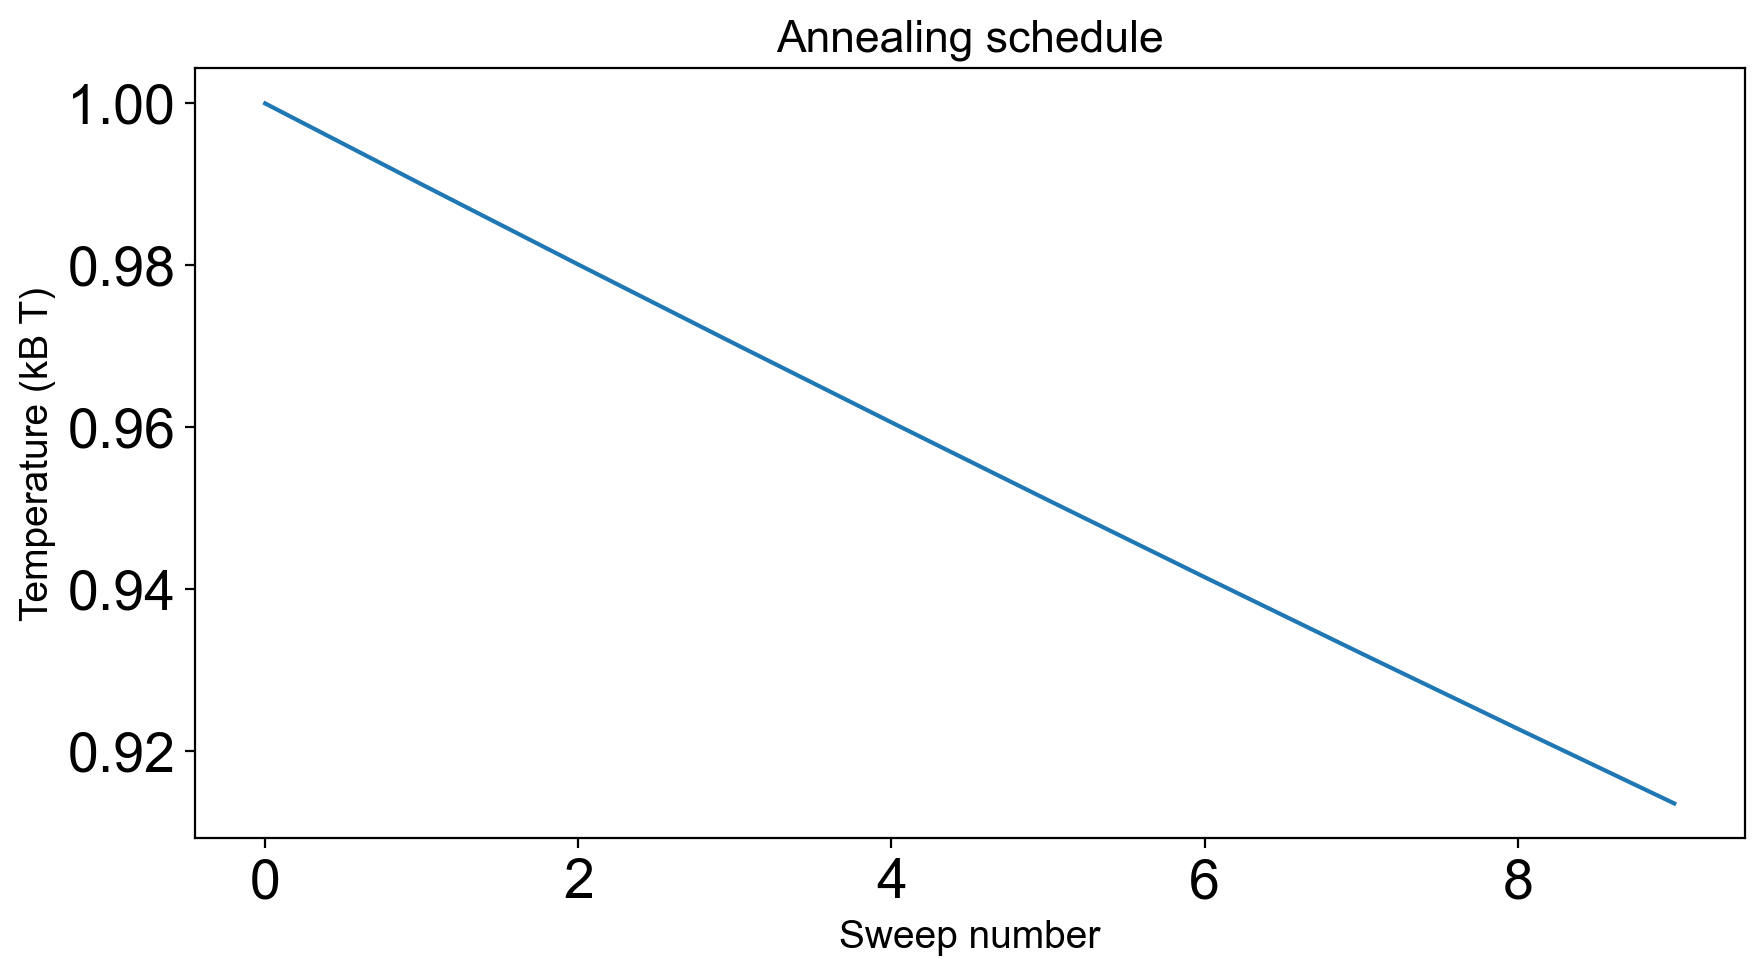

In [7]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

Plot results

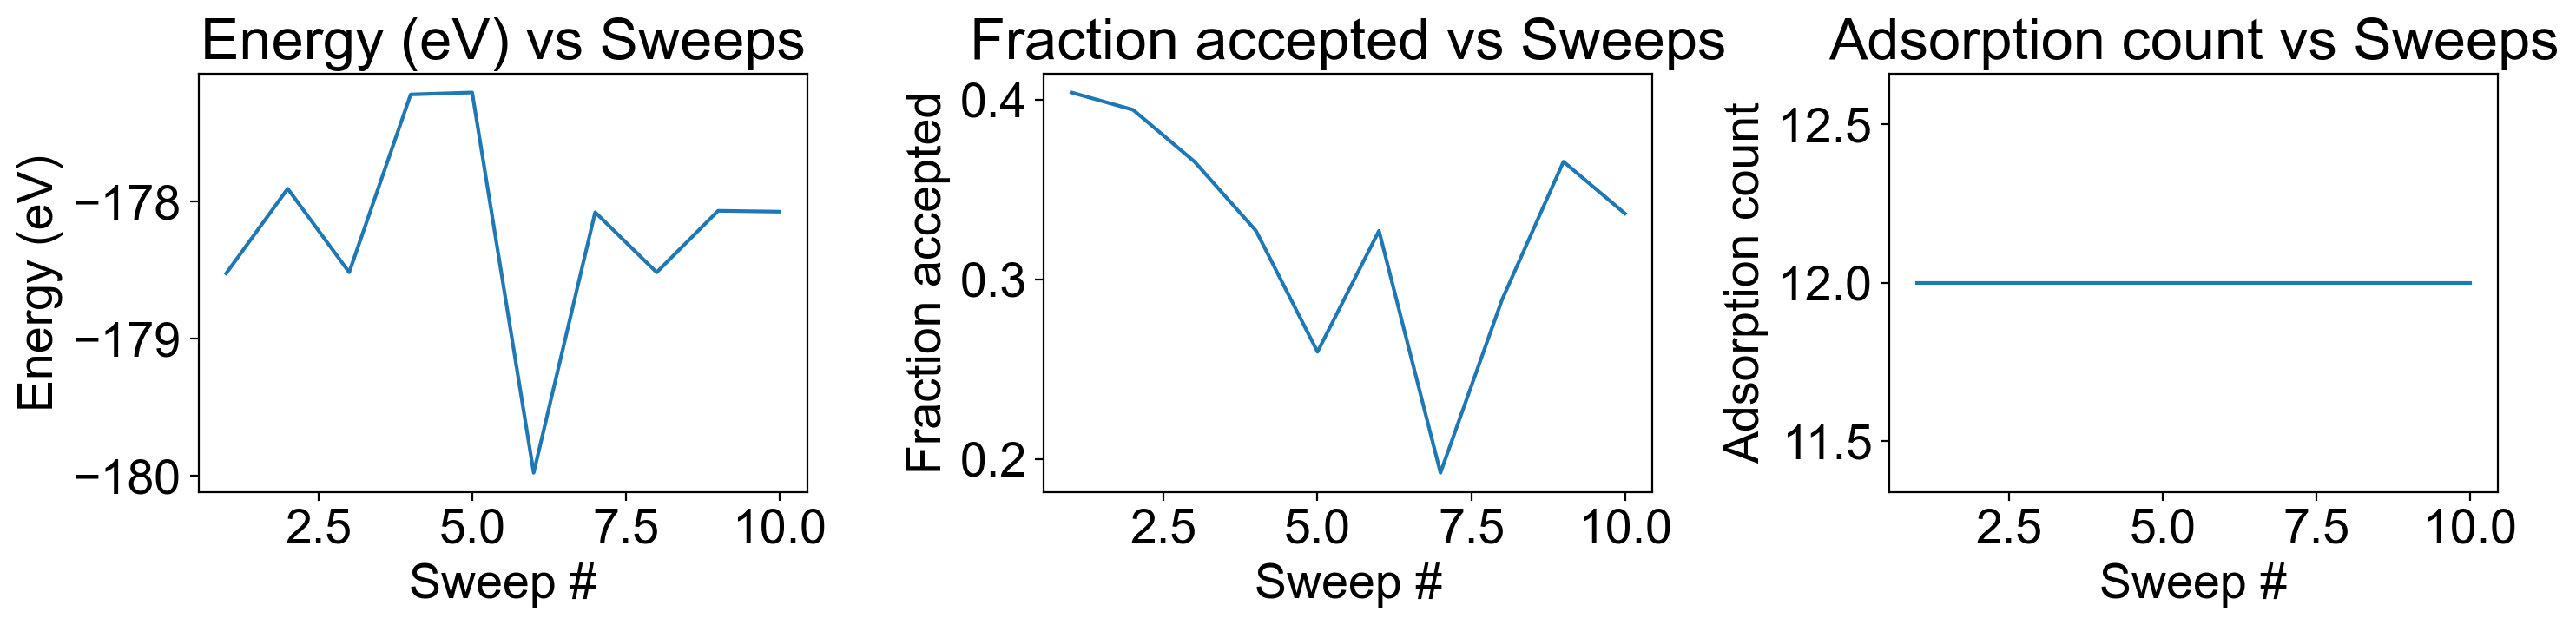

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)